In [8]:
#include <iostream>
#include <xtensor/xarray.hpp>
#include <xtensor/xio.hpp>
#include <xtensor/xview.hpp>
#include <xtensor/xarray.hpp>
#include <xtensor/xfixed.hpp>
#include <xtensor/xio.hpp>
#include <xtensor/xtensor.hpp>
#include <xtensor/xadapt.hpp>
#include <xtensor/xarray.hpp>
#include <xtensor/xaxis_slice_iterator.hpp>
#include <xtensor/xaxis_iterator.hpp>
#include <xtensor/xio.hpp>
#include <xtensor/xarray.hpp>
#include <xtensor/xindex_view.hpp>
#include <xtensor/xchunked_array.hpp>
#include <xtensor/xfixed.hpp>
#include <cstddef>
#include <vector>
#include <xtensor/xarray.hpp>
#include <xtensor/xadapt.hpp>
#include <istream>
#include <fstream>
#include <iostream>
#include <xtensor/xarray.hpp>
#include <xtensor/xcsv.hpp>
#include <iostream>
#include <fstream>
#include <functional>
#include <cstdio>
#include <xtensor/xcsv.hpp>
#include <xcpp/xdisplay.hpp>
#include <xtensor/xsort.hpp>

using namespace xt;
using namespace xt::placeholders;  // to enable _ syntax

#include <iostream>
#include <fstream>
using namespace std;

#include <chrono>
using namespace std::chrono;

In [9]:
double current_time(){
    auto current_time = std::chrono::system_clock::now();
    auto duration_in_seconds = std::chrono::duration<double>(current_time.time_since_epoch());
    double num_seconds = duration_in_seconds.count();
    return num_seconds;
}

# Load data

In [10]:
ofstream outfile;
outfile.open("../out/LOG_dbscanrn_cpp_compound_dataset_D2_R12_k2_cosine_dissimilarity_rMin.log");

auto start =  chrono::high_resolution_clock::now();

ifstream input_file;
input_file.open("../data/compound_dataset.txt");
auto data = load_csv<double>(input_file);
input_file.close();

auto end =  chrono::high_resolution_clock::now();
duration<double> elapsed = (end - start);
outfile << std::setprecision (16) << current_time() << ",reading_data," <<
    ",," << elapsed.count() << ',' << endl;

data.reshape(data.shape());
xarray<double> X = view(data, all(), range(0, 2));

# Similarity



In [11]:
float cosine_dissimilarity(const xarray<double>& a, const xarray<double>& b){ 
    auto numerator = sum(a * b);
    auto denominator = sqrt(sum(pow(a, 2))) * sqrt(sum(pow(b, 2)));
    auto result = numerator / denominator;
    return 1 - result(0);
}

# Normalization

In [12]:
auto normalize(const xarray<double>& a){ 
    xarray<double> result = a / sqrt(sum(pow(a, 2)));
    return result;
}

# Clusterization

In [13]:
auto dbscanrn(const xarray<float>& X_original, int k)
{
    outfile << std::setprecision (16) << current_time() << ",start log,,," << endl;
    
    // normalization
    auto start =  chrono::high_resolution_clock::now();
    xarray<float> X = normalize(X_original);
    auto end =  chrono::high_resolution_clock::now();
    std::chrono::duration<double> elapsed = end - start;

    outfile << std::setprecision (16) << current_time() << ",normalization_time," <<
        ",," << elapsed.count() << ',' << endl;
    
    // each data point can be in one of 3 stages
    int NOT_VISITED = -1; // not visited point
    int VISITED = 0; // non-core point
    int CLUSTERED = 1; // core point

    // initial setup
    int n = X.shape()[0];
    xarray<double> cluster = ones<double>({n}) * -1; // cluster register
    xarray<double> state = ones<double>({n}) * NOT_VISITED; // state register
    int cluster_id = 1;
    auto all_point_indices = arange(n);
    map<int, vector<int>> point_rnn;
    map<int, xarray<int>> point_knn;
    
    auto get_knn = [&] (int current_index, xarray<int> neighbor_indices, int k){
        xarray<float> neighbor_similaritys = {0};
        for (auto& neighbor_index : neighbor_indices) {
            
            outfile << std::setprecision (16) << current_time() << ",similarity_calculation," <<
                current_index << ",," << endl;
            
            auto similarity = cosine_dissimilarity(
                row(X, neighbor_index), row(X, current_index)
            );
            neighbor_similaritys = concatenate(
                xtuple(neighbor_similaritys, xarray<float> {similarity})
            );
        };
        xarray<int> sort_indices = argsort(view(neighbor_similaritys, range(1, all())));
        xarray<int> neighbor_indices_sorted = index_view(neighbor_indices, sort_indices); 
        point_knn[(int) current_index] = view(neighbor_indices_sorted, range(0, k));  
        
        outfile << std::setprecision (16) << current_time() << ",knn_neighbors_id," <<
                current_index << ",";
        for(auto& i : point_knn[(int) current_index]) {outfile << i << ";"; }
        outfile << endl;
        outfile << std::setprecision (16) << current_time() << ",|knn_neighbors|," <<
        current_index << "," << (int) point_knn[(int) current_index].shape(0) << "," << endl;
    };    
    
    auto get_pointwise_rnn = [&] (int current_index){
        vector<int> rnn;
        for (auto& neighbor_index : point_knn[(int) current_index]) {
            if ((point_knn[(int) neighbor_index], (int) current_index)) {
                rnn.push_back((int) neighbor_index);
            };
        };
        
        point_rnn[(int) current_index] = rnn;
    };
    
    auto get_rnn = [&] (){
        
        auto start =  chrono::high_resolution_clock::now();
        for (int current_index = 0; current_index < n; current_index++) {
            // remove current index from neighbors
            xarray<int> neighbor_indices = col(
                from_indices(argwhere(not_equal(all_point_indices, current_index))), 0
            );
            get_knn((int) current_index, neighbor_indices, k);
        };
        auto end = chrono::high_resolution_clock::now();
        std::chrono::duration<double> elapsed = end - start;
        
        outfile << std::setprecision (16) << current_time() << ",knn_time," <<
            ",," << elapsed.count() << ',' << endl;
        
        start =  chrono::high_resolution_clock::now();
        for (int current_index =  0; current_index < n; current_index++) {
            get_pointwise_rnn((int) current_index);
            outfile << std::setprecision (16) << current_time() << ",|rnn_neighbors|," <<
                current_index << "," << (int) point_knn[(int) current_index].shape(0) << 
                "," << endl;
        };
        end = chrono::high_resolution_clock::now();
        elapsed = end - start;
        
        outfile << std::setprecision (16) << current_time() << ",rnn_time," <<
            ",," << elapsed.count() << ',' << endl;
    };

    // extend cluster
    function < void( int ) > search = [&] (int current_index) -> void {
        if (point_rnn[(int) current_index].size() <  k) {
            state[(int) current_index] = VISITED;
        } else {
            state[(int) current_index] = CLUSTERED;
            cluster[(int) current_index] = cluster_id;
            for (auto& neighbor_index : point_rnn[(int) current_index]) {
                if (state[(int) neighbor_index] == NOT_VISITED) {
                    search(neighbor_index);
                };
                state[(int) neighbor_index] = CLUSTERED;
                cluster[(int) neighbor_index] = cluster_id;
            };
        };
    };
    
    get_rnn();
    
    // visit all points
    while (any(equal(state, NOT_VISITED))){
        xarray<int> idx = from_indices(argwhere(equal(state, NOT_VISITED)));
        search(idx(0,0));
        cluster_id++;
    }

    // clusterize all outlier points to nearest cluster 
    while (any(equal(state, VISITED))){
        xarray<int> idx_not_clustered = from_indices(argwhere(equal(state, VISITED)));
        xarray<int> idx_clustered = from_indices(argwhere(equal(state, CLUSTERED)));
        get_knn((int) idx_not_clustered(0,0), idx_clustered, 1);
        auto closest_clustered_idx = point_knn[(int) idx_not_clustered(0,0)](0);
        cluster[(int) idx_not_clustered(0,0)] = cluster[(int) closest_clustered_idx];
        state[(int) idx_not_clustered(0,0)] = CLUSTERED;
    }
    outfile << std::setprecision (16) << current_time() << ",stop log,,," << endl;
    return cluster;
}

auto y_pred = dbscanrn(X, 4);
// y_pred

# Save output to csv

In [14]:
start = chrono::high_resolution_clock::now();

ofstream out_file;
out_file.open("../out/dbscanrn_cpp_compound_dataset.csv");
dump_csv(out_file, view(y_pred, all(), newaxis()));
out_file.close();

duration<double> elapsed = (chrono::high_resolution_clock::now() - start);
outfile << std::setprecision (16) << current_time() << ",writing_data," <<
    ",," << elapsed.count() << ',' << endl;
outfile.close();

# To execute following cells change kernel into python 

In [1]:
cd ..

/work


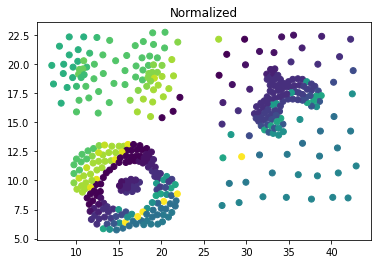

In [4]:
import pandas as pd
from src.datasets import Dataset
from src.utils import *

dataset = Dataset('./data/compound_dataset.txt')
X, y = dataset.X, dataset.y
c = pd.read_csv("./out/dbscanrn_cpp_compound_dataset.csv", header=None)
display_points(X, c, 'Normalized', numerate=False)